# **Predictive Modeling**

Joseph Lardie

November 2023

# **Imports**

In [1]:
#Numpy
import numpy as np

#Pandas
import pandas as pd

#Seaborn
import seaborn as sns

#matplotlib
import matplotlib.pyplot as plt
import plotly
%matplotlib inline

# Standard imports
import re

#sklearn
from sklearn import preprocessing
from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer 
from sklearn.metrics import r2_score, confusion_matrix, roc_auc_score, roc_curve, classification_report, mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

# warnings
import warnings
warnings.filterwarnings("ignore")
set_config(display = 'diagram')

# **Loading Data**

In [2]:
# Loading NYC Restaraunt Inspections Data
rdf = pd.read_csv('rdf')

In [3]:
# Glance of Inspections Data
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211180 entries, 0 to 211179
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  211180 non-null  int64  
 1   DBA                    210501 non-null  object 
 2   BORO                   211180 non-null  object 
 3   BUILDING               210883 non-null  object 
 4   STREET                 211177 non-null  object 
 5   ZIPCODE                208492 non-null  float64
 6   CUISINE DESCRIPTION    208713 non-null  object 
 7   INSPECTION DATE        211180 non-null  object 
 8   ACTION                 208713 non-null  object 
 9   VIOLATION CODE         207585 non-null  object 
 10  VIOLATION DESCRIPTION  207585 non-null  object 
 11  CRITICAL FLAG          211180 non-null  object 
 12  SCORE                  201018 non-null  float64
 13  GRADE                  103218 non-null  object 
 14  GRADE DATE             94397 non-nul

# **Data Cleaning**

In [4]:
# Dropping irrelevant columns that do not affect predicting the classification question of will a restaurant pass an inspection
rdf.drop(['Latitude', 'Longitude', 'Council District', 'ZIPCODE', 'CRITICAL FLAG', 'BUILDING', 'STREET', 'ACTION', 'GRADE'], axis=1, inplace=True)

In [5]:
# Inspection data after dropping irrelevant columns
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211180 entries, 0 to 211179
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  211180 non-null  int64  
 1   DBA                    210501 non-null  object 
 2   BORO                   211180 non-null  object 
 3   CUISINE DESCRIPTION    208713 non-null  object 
 4   INSPECTION DATE        211180 non-null  object 
 5   VIOLATION CODE         207585 non-null  object 
 6   VIOLATION DESCRIPTION  207585 non-null  object 
 7   SCORE                  201018 non-null  float64
 8   GRADE DATE             94397 non-null   object 
 9   INSPECTION TYPE        208713 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 16.1+ MB


In [6]:
# Filter to eliminate restaurants that have not yet recieved their inspection
def filter_inspected_restaurants(rdf):
    # Filter out rows with '1/1/1900' date
    filtered_dataframe = rdf[rdf['INSPECTION DATE'] != '1900-01-01']

    return filtered_dataframe
# Applying the filter function to the column Inpection date
rdf = filter_inspected_restaurants(rdf)

In [7]:
# Convert 'INSPECTION DATE' to datetime if not already in datetime format
rdf['INSPECTION DATE'] = pd.to_datetime(rdf['INSPECTION DATE'], errors='coerce')

# Remove rows with inspection date before 2020
rdf = rdf[rdf['INSPECTION DATE'].dt.year >= 2020].copy()

# If you want to modify the original dataframe in place, you can use inplace=True
# rdf = rdf[rdf['INSPECTION DATE'].dt.year >= 2020].copy(inplace=True)

# Display the number of removed rows
print("Number of rows removed:", len(rdf))

Number of rows removed: 198222


In [8]:
# Display the number of duplicate rows in the dataset
print(f'There are {rdf.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


In [9]:
#Dropping duplicated Rows
rdf = rdf.drop_duplicates()

In [10]:
# Comfirming there are no more duplicates 
print(f'There are {rdf.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


In [11]:
#Checking for missing values
rdf[rdf.isna().any(axis=1)].shape

(109874, 10)

In [12]:
#Identifying the columns containing missing values
rdf.isna().sum()

CAMIS                         0
DBA                           0
BORO                          0
CUISINE DESCRIPTION           0
INSPECTION DATE               0
VIOLATION CODE              934
VIOLATION DESCRIPTION       934
SCORE                      7323
GRADE DATE               109564
INSPECTION TYPE               0
dtype: int64

In [13]:
# Function to clean restaurant names
def clean_restaurant_name(name):
    # Check if the input is a string
    if isinstance(name, str):
        # Remove store numbers using regular expression
        cleaned_name = re.sub(r'#\d+', '', name)
        
        # Remove all numeric characters
        cleaned_name = re.sub(r'\d+', '', cleaned_name)
    
        # Remove leading and trailing whitespace
        cleaned_name = cleaned_name.strip()
    
        return cleaned_name
    else:
        return name  # Return the input unchanged for non-string values

# Apply the clean_restaurant_name function to the 'DBA' column
rdf['Cleaned Restaurant Name'] = rdf['DBA'].apply(clean_restaurant_name)

# Drop the original 'DBA' column if you want
rdf.drop(columns=['DBA'], inplace=True)

In [14]:
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198222 entries, 19 to 211179
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CAMIS                    198222 non-null  int64         
 1   BORO                     198222 non-null  object        
 2   CUISINE DESCRIPTION      198222 non-null  object        
 3   INSPECTION DATE          198222 non-null  datetime64[ns]
 4   VIOLATION CODE           197288 non-null  object        
 5   VIOLATION DESCRIPTION    197288 non-null  object        
 6   SCORE                    190899 non-null  float64       
 7   GRADE DATE               88658 non-null   object        
 8   INSPECTION TYPE          198222 non-null  object        
 9   Cleaned Restaurant Name  198222 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 16.6+ MB


In [15]:
# Filtering out only the initial inspections and re-inspections
def filter_inspection_type(rdf):
    """
    Filter rows based on the values in the "INSPECTION TYPE" column.

    Returns:
    - DataFrame containing only rows with specified inspection types
    """
    inspection_types_to_keep = ['Cycle Inspection / Initial Inspection', 'Cycle Inspection / Re-inspection']
    filtered_rdf = rdf.loc[rdf['INSPECTION TYPE'].isin(inspection_types_to_keep)]

    return filtered_rdf

rdf = filter_inspection_type(rdf)

In [16]:
# Function for value counts of the columns 
for col in rdf.columns:
    print(rdf[col].value_counts())

40365904    58
41406895    58
50089474    50
41658324    46
50045647    45
            ..
50072002     1
50104959     1
50106402     1
50002380     1
50118088     1
Name: CAMIS, Length: 19981, dtype: int64
Manhattan        52875
Brooklyn         39449
Queens           32959
Bronx            12634
Staten Island     5303
Name: BORO, dtype: int64
American             24263
Chinese              14048
Coffee/Tea            9439
Pizza                 9189
Latin American        6122
                     ...  
Czech                   12
Iranian                  9
Basque                   8
Fruits/Vegetables        7
Haute Cuisine            5
Name: CUISINE DESCRIPTION, Length: 87, dtype: int64
2023-02-15    504
2023-02-16    497
2023-03-16    471
2023-02-23    463
2022-05-12    460
             ... 
2023-10-01      1
2022-04-23      1
2023-09-29      1
2023-11-19      1
2023-09-30      1
Name: INSPECTION DATE, Length: 754, dtype: int64
10F      21325
08A      16837
06D      10684
04L      1046

## **Selecting Brooklyn Restaurants**

In [17]:
# Selecting subset of only restaurants from Brooklyn
rdf = rdf[rdf['BORO'].str.lower() == 'brooklyn']

In [18]:
# Handling missing values and date columns
rdf['INSPECTION DATE'] = pd.to_datetime(rdf['INSPECTION DATE'], errors='coerce')
rdf['year'] = rdf['INSPECTION DATE'].dt.year
rdf['month'] = rdf['INSPECTION DATE'].dt.month
rdf['day'] = rdf['INSPECTION DATE'].dt.day

In [19]:
# Dropping 'BORO' and 'CUISINE DESCRIPTION' now that only restaurants in Brooklyn remain
rdf.drop(['BORO', 'CUISINE DESCRIPTION', 'GRADE DATE', 'INSPECTION TYPE', 'INSPECTION DATE'], axis=1, inplace=True)

In [20]:
# Looking at the remaining data after cleaning
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39449 entries, 38 to 211176
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CAMIS                    39449 non-null  int64  
 1   VIOLATION CODE           39405 non-null  object 
 2   VIOLATION DESCRIPTION    39405 non-null  object 
 3   SCORE                    39449 non-null  float64
 4   Cleaned Restaurant Name  39449 non-null  object 
 5   year                     39449 non-null  int64  
 6   month                    39449 non-null  int64  
 7   day                      39449 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 2.7+ MB


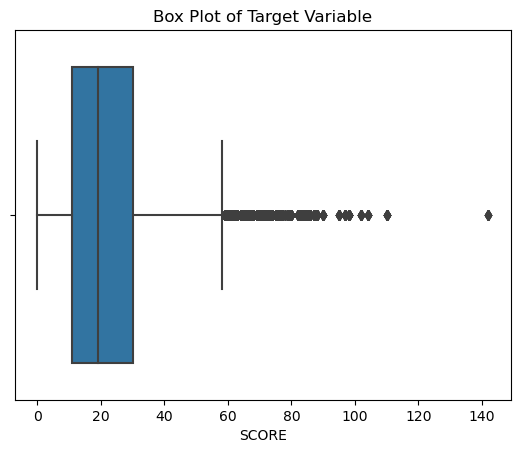

Number of outliers removed: 1584


In [21]:
# Check for outliers using a box plot
sns.boxplot(x=rdf['SCORE'])
plt.title("Box Plot of Target Variable")
plt.show()

# Calculate the IQR (Interquartile Range)
Q1 = rdf['SCORE'].quantile(0.25)
Q3 = rdf['SCORE'].quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify and remove outliers
outliers = (rdf['SCORE'] < lower_bound) | (rdf['SCORE'] > upper_bound)
rdf = rdf[~outliers]

# Display the number of removed outliers
print("Number of outliers removed:", sum(outliers))

In [22]:
# Remove outliers directly in the dataframe with inplace=True
rdf = rdf[(rdf['SCORE'] >= lower_bound) & (rdf['SCORE'] <= upper_bound)]
rdf.reset_index(drop=True, inplace=True)

# Display the number of removed outliers
print("Number of outliers removed:", len(rdf))

Number of outliers removed: 37865


In [23]:
#Checking for missing values
rdf[rdf.isna().any(axis=1)].shape

(44, 8)

# **Predicting Scores**

# **Validation Split**

In [24]:
# Defining the target variable
X= rdf.drop('SCORE', axis=1)
y= rdf['SCORE']

# **Data Preprocessing**

In [25]:
# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Check for missing values
print("Missing values in X_train:", X_train.isnull().sum().sum())
print("Missing values in y_train:", y_train.isnull().sum().sum())

# Check data types
print("Data types in X_train:\n", X_train.dtypes)
print("Data type in y_train:", y_train.dtypes)


Missing values in X_train: 78
Missing values in y_train: 0
Data types in X_train:
 CAMIS                       int64
VIOLATION CODE             object
VIOLATION DESCRIPTION      object
Cleaned Restaurant Name    object
year                        int64
month                       int64
day                         int64
dtype: object
Data type in y_train: float64


In [27]:
#Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy= 'mean')

# Standard Scaler
scaler = StandardScaler()

# OneHotEncoder
ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')

# Instantiate the selectors
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

# Forming pipelines
num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)

#Create Tuples
num_tuple = ('num', num_pipe, num_selector)
cat_tuple = ('cat', cat_pipe, cat_selector)

#Make tuples for preprocessing the categorical and numeric columns
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)  

#Create Column Transformer
preprocessor= make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')

In [28]:
# Looking at how the preprocessor is organized
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000020AB94FCA90>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000020AB94FC8E0>)])

## **Linear Regression Model**

In [29]:
# Create the final pipeline with the preprocessor and the linear regression model
lr_model = make_pipeline(preprocessor, LinearRegression())

In [30]:
# Train the model
lr_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020AB94FCA90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020AB94FC8E0>)])),
                ('linearregression', LinearRegression())])

In [31]:
# Make predictions on the training set
y_train_pred = lr_model.predict(X_train)

# Make predictions on the test set
y_test_pred = lr_model.predict(X_test)

In [32]:
# Evaluate the model
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Training RMSE: 8.71495642617855
Test RMSE: 28672155257.415455


## **Ridge Model**

In [33]:
# Create a Ridge regression model
ridge_model = Ridge(alpha= 3.4) 

# Create a pipeline
ridge = make_pipeline(preprocessor, ridge_model)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
ridge.fit(X_train, y_train)

# Make predictions
y_pred = ridge.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nRidge Model:")
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Ridge Model:
Mean Squared Error: 99.6714570625092
R-squared: 0.43219882295656


Mean Squared Error: 92.96954973203182
R-squared: 0.47037776588396785


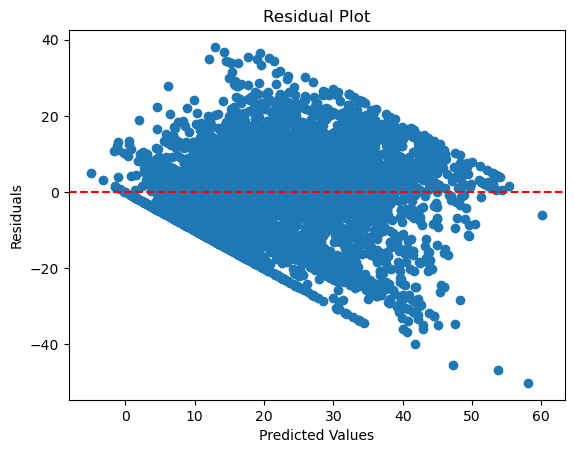

In [34]:
# Hyperparameter Tuning using Grid Search
param_grid = {
    'ridge__alpha': [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0],
    'ridge__fit_intercept': [True, False]
}
# Use GridSearchCV
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')
grid_search.fit(X_train, y_train)

# Access the best model from GridSearchCV
best_r_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_r_model.predict(X_test)

# Evaluate on Test Set
# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

# Residual Plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

## **Gradient Boosting**

In [35]:
# Create gradient boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state= 42)

gb_pipeline = make_pipeline(preprocessor, gb_model)

# Train gradient boosting model
gb_pipeline.fit(X_train, y_train)
y_pred_gb = gb_pipeline.predict(X_test)

In [36]:
# Evaluate gradient boosting model
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print("\nGradient Boosting:")
print("Mean Squared Error:", mse_gb)
print("R-squared:", r2_gb)


Gradient Boosting:
Mean Squared Error: 156.64606338477654
R-squared: 0.10762998966378012


## **KNN Model**

In [37]:
# Create the k-Nearest Neighbors model
knn_model = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors (n_neighbors) as needed

# Create the final pipeline with the preprocessor and the k-Nearest Neighbors model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('knn', knn_model)])

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate on Test Set
# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Squared Error: 189.14253796381885
R-squared: -0.07749358592687794
